In [5]:
import os
import cv2
import numpy as np
import habitat
from env import Env
import quaternion
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
!ln -s /data/ ./data

In [7]:
from arguments import init_config
config = init_config()

In [42]:
print(config)

DATASET:
  CONTENT_SCENES: ['*']
  DATA_PATH: /data/v1/{split}/{split}.json.gz
  SCENES_DIR: /data
  SPLIT: train
  TYPE: PointNav-v1
ENVIRONMENT:
  ITERATOR_OPTIONS:
    CYCLE: True
    GROUP_BY_SCENE: True
    MAX_SCENE_REPEAT_EPISODES: -1
    MAX_SCENE_REPEAT_STEPS: 10000
    NUM_EPISODE_SAMPLE: -1
    SHUFFLE: False
    STEP_REPETITION_RANGE: 0.2
  MAX_EPISODE_SECONDS: 10000000
  MAX_EPISODE_STEPS: 5000
PYROBOT:
  BASE_CONTROLLER: proportional
  BASE_PLANNER: none
  BUMP_SENSOR:
    TYPE: PyRobotBumpSensor
  DEPTH_SENSOR:
    CENTER_CROP: False
    HEIGHT: 480
    MAX_DEPTH: 5.0
    MIN_DEPTH: 0.0
    NORMALIZE_DEPTH: True
    TYPE: PyRobotDepthSensor
    WIDTH: 640
  LOCOBOT:
    ACTIONS: ['BASE_ACTIONS', 'CAMERA_ACTIONS']
    BASE_ACTIONS: ['go_to_relative', 'go_to_absolute']
    CAMERA_ACTIONS: ['set_pan', 'set_tilt', 'set_pan_tilt']
  RGB_SENSOR:
    CENTER_CROP: False
    HEIGHT: 480
    TYPE: PyRobotRGBSensor
    WIDTH: 640
  ROBOT: locobot
  ROBOTS: ['locobot']
  SENSORS: ['

In [8]:
config['DATASET']['DATA_PATH'] = '/data/v1/{split}/{split}.json.gz'
config['DATASET']['SCENES_DIR'] = '/data'
config['DATASET']['SPLIT'] = 'train'
env = Env(config=config)
print("Environment creation successful")

2020-05-31 01:45:07,107 Initializing dataset PointNav-v1
2020-05-31 01:47:08,269 initializing sim Sim-v0
2020-05-31 01:47:14,470 Initializing task Nav-v0


Environment creation successful


In [9]:
res = env.reset()[0]

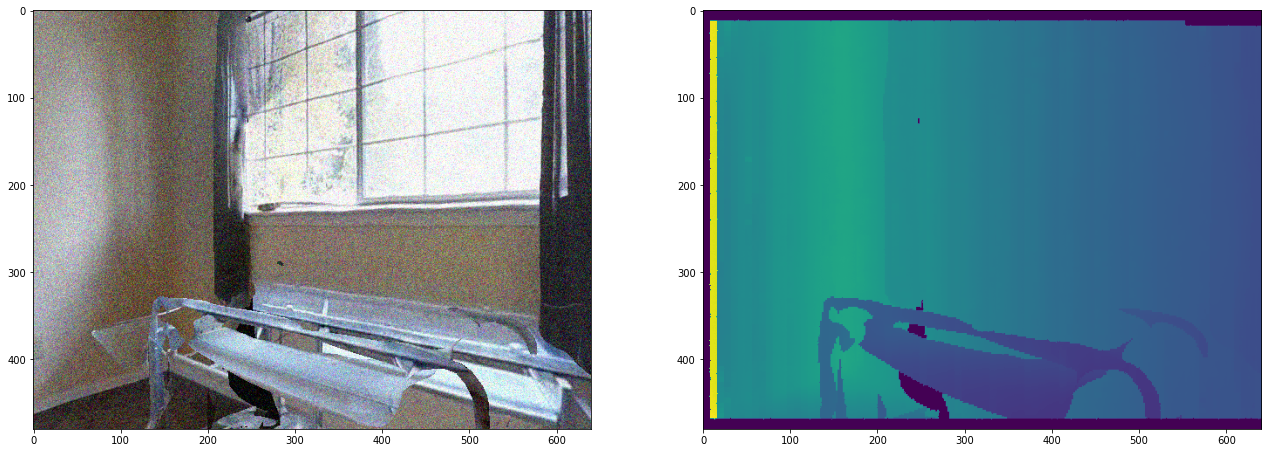

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
plt.subplot(121)
plt.imshow(res['rgb'])
plt.subplot(122)
plt.imshow(res['depth'][:,:,0])
plt.show()

Step #1:
--gps: [0.00261358 0.03035226]
--pos: [-1.086584650281548, -5.77837434093909]
--compass: [0.36372572]


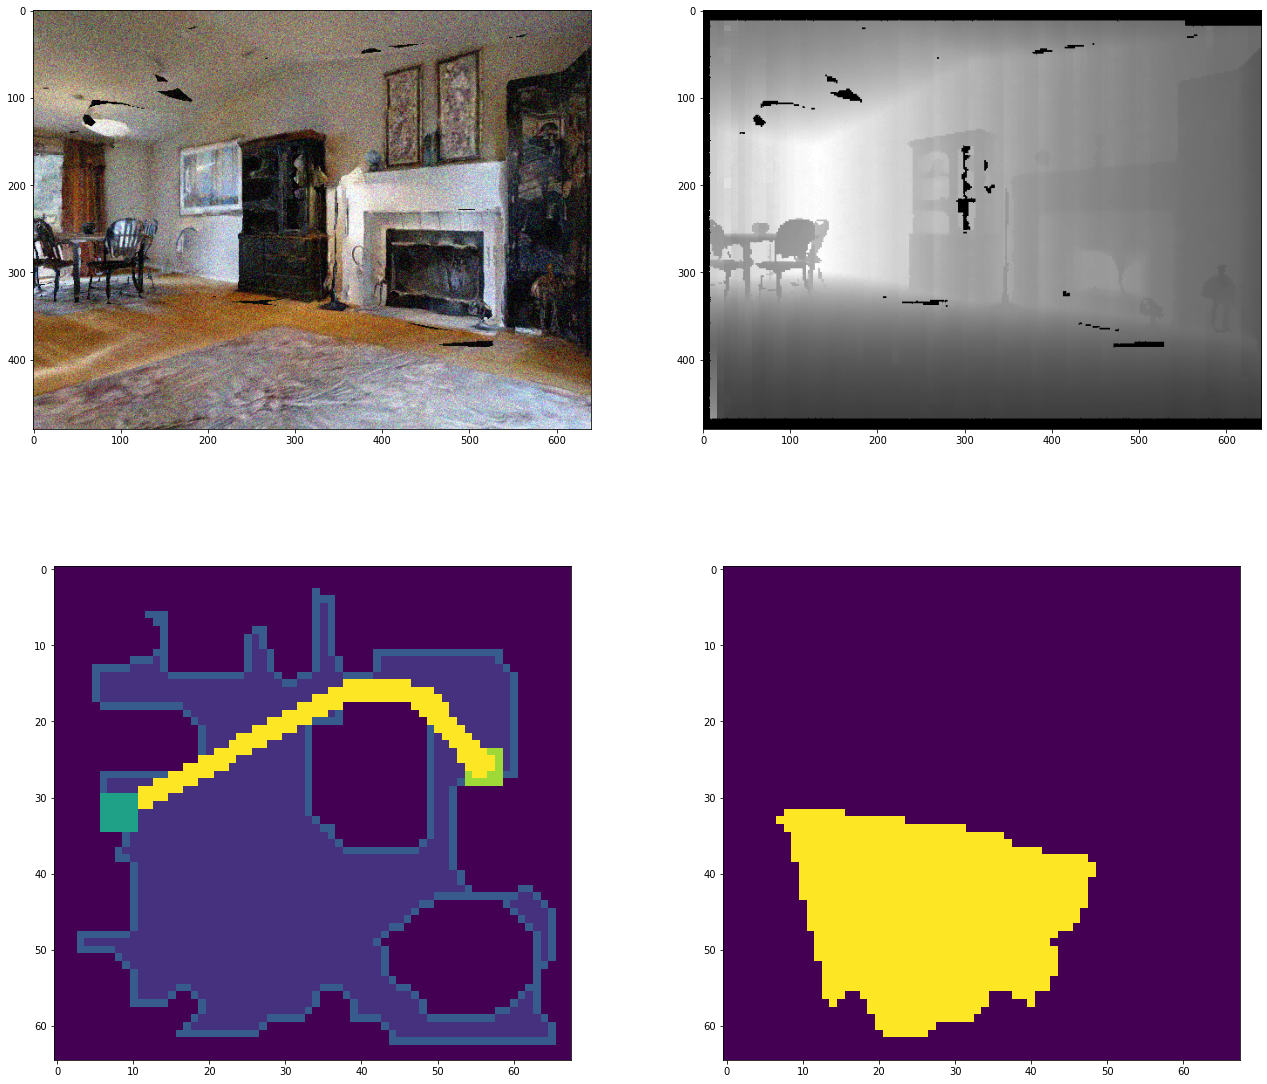

In [43]:
res = env.reset()[0]
done = False
ind = 0
while not done:
    observations, info, done = env.step(0, ideal_action=True)
    ind += 1
    print('Step #{}:\n--gps: {}\n--pos: {}\n--compass: {}'.format(ind, observations['gps'], observations['pos'], observations['compass']))
    
    fig, ax = plt.subplots(2, 2, figsize=(22, 20))
    plt.subplot(221)
    plt.imshow(observations['rgb'])
    plt.subplot(222)
    plt.imshow(observations['depth'][:,:,0], cmap='gray')
    plt.subplot(223)
    plt.imshow(info['top_down_map']['map'])
    plt.subplot(224)
    plt.imshow(info['top_down_map']['fog_of_war_mask'])
    plt.show()
    break

In [38]:
def q_to_axisangle(q):
    # from quaternion to vector of rotation and angle of rotation
    w, v = q.a.real, (q.x, q.y, q.z)
    theta = np.arccos(np.sign(q.y) * w) * 2.0
    return theta / np.pi * 180 % 360

In [51]:
path_x

array([-4.683774 , -4.683774 , -4.683774 , -4.683774 , -4.694062 ,
       -4.693774 , -4.693774 , -4.6573505, -4.652791 , -4.640486 ,
       -4.638299 , -4.6675196, -4.907795 , -5.107697 , -5.315096 ,
       -5.342364 , -5.5595474, -5.5492673, -5.812609 , -5.7873764,
       -5.7901425, -6.0035048, -5.99583  , -6.027406 , -6.094662 ,
       -6.037431 , -6.020021 , -6.062859 , -5.983296 , -5.9387474,
       -5.9387474], dtype=float32)

In [82]:
seq_num = 0
save_path = '/root/DF-VO/dataset/custom'

In [ ]:
add_redun = 0
show_images = False
show_path = True
assert add_redun >= 0

!cd $save_path
seq_path = os.path.join(save_path, str(seq_num))
!mkdir $seq_path
rgb_path = os.path.join(seq_path, 'rgb')
depth_path = os.path.join(seq_path, 'depth')
!mkdir $rgb_path
!mkdir $depth_path

done = False
res = env.reset()[0]
pos_start = env.sim.get_agent_state().position
# pos_start = np.zeros(3).astype(np.float32)
w, x, y, z = env.sim.get_agent_state().rotation.components
# q_rev = quaternion.quaternion(w,-x,-y,-z) / (w*w + x*x + y*y + z*z)
# global_rot = quaternion.quaternion(1,0,1,0) * q_rev
ind = 0
cv2.imwrite(os.path.join(rgb_path, '{:.06f}.png'.format(ind)), observations['rgb'])
cv2.imwrite(os.path.join(depth_path, '{:.06f}.png'.format(ind)), observations['depth']*255)
with open(os.path.join(seq_path, 'rgb.txt'), 'a') as f:
    f.write('{} {:.06f}.png\n'.format(ind, ind))
with open(os.path.join(seq_path, 'depth.txt'), 'a') as f:
    f.write('{} {:.06f}.png\n'.format(ind, ind))
with open(os.path.join(seq_path, 'groundtruth.txt'), 'a') as f:
    pos = env.sim.get_agent_state().position - pos_start
#     q = global_rot * env.sim.get_agent_state().rotation
    q = env.sim.get_agent_state().rotation
    f.write('{} {} {} {} {} {} {} {}\n'.format(ind, pos[2], pos[1], pos[0], q.x, q.y, q.z, q.w))    

path_x = np.array([pos[2]])
path_y = np.array([pos[0]])

while not done:
    if not ind % (add_redun + 1):
        observations, info, done = env.step(0, ideal_action=True)
    else:
        action = np.random.randint(1, 4)
        observations, info, done = env.step(action, ideal_action=False)
    ind += 1
    cv2.imwrite(os.path.join(rgb_path, '{:.06f}.png'.format(ind)), observations['rgb'])
    cv2.imwrite(os.path.join(depth_path, '{:.06f}.png'.format(ind)), observations['depth']*255)
    with open(os.path.join(seq_path, 'rgb.txt'), 'a') as f:
        f.write('{} {:.06f}.png\n'.format(ind, ind))
    with open(os.path.join(seq_path, 'depth.txt'), 'a') as f:
        f.write('{} {:.06f}.png\n'.format(ind, ind))
    with open(os.path.join(seq_path, 'groundtruth.txt'), 'a') as f:
        pos = env.sim.get_agent_state().position - pos_start
        # q = global_rot * env.sim.get_agent_state().rotation
        q = env.sim.get_agent_state().rotation
        f.write('{} {} {} {} {} {} {} {}\n'.format(ind, pos[2], pos[1], pos[0], q.x, q.y, q.z, q.w))
    path_x = np.append(path_x, pos[2])
    path_y = np.append(path_y, pos[0])
    if show_images:
        fig, ax = plt.subplots(1, 2, figsize=(20,10))
        fig.suptitle('#{}:\npos: ({:.6} {:.6} {:.6})\nrot: ({:.4} {:.4} {:.4} {:.4})\nang: {}'.format(ind, *pos, q.x, q.y, q.z, q.w, q_to_axisangle(q)))
        plt.subplot(121)
        plt.imshow(observations['rgb'])
        plt.subplot(122)
        # plt.xlim([-1,1])
        # plt.ylim([-1,1])
        plt.quiver(path_x[:-1], path_y[:-1], path_x[1:]-path_x[:-1],
                   path_y[1:]-path_y[:-1], scale_units='xy', angles='xy', scale=1.)
        # plt.plot(path_x, path_y, '.r-')
        plt.show()

if show_path:
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    plt.subplot(121)
    plt.quiver(path_x[:-1], path_y[:-1], path_x[1:]-path_x[:-1],
               path_y[1:]-path_y[:-1], scale_units='xy', angles='xy', scale=1.)
    plt.subplot(122)
    plt.imshow(info['top_down_map']['map'])
    plt.show()

seq_num += 1

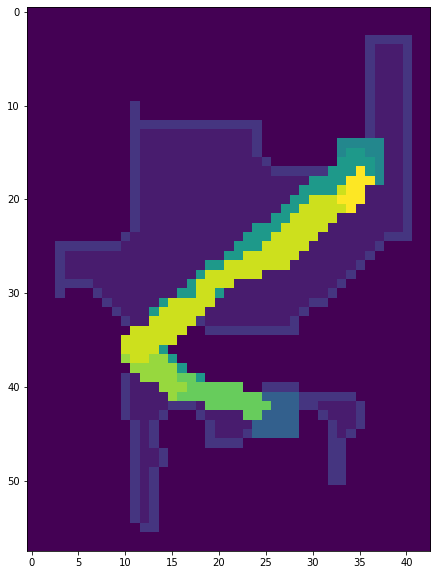

In [104]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(info['top_down_map']['map'])
plt.show()

In [186]:
w, x, y, z = 0.1, 0, 8, 0
w2, y2 = np.random.rand(2)
q1 = quaternion.quaternion(w,x,y,z)
q2 = quaternion.quaternion(w,-x,-y,-z) / (w*w + x*x + y*y + z*z)  # q1**-1
q3 = quaternion.quaternion(w2,x,y2,z)

In [187]:
q4 = quaternion.quaternion(1,0,1,0) * q2

In [188]:
q4 * q3

quaternion(0.167042502723138, 0, -0.00598072582568723, 0)

In [62]:
!ln -s ../DF-VO ./DF-VO

In [67]:
from pose_evaluation_utils import *

In [69]:
q = [0.0, 0.9345473051071167, 0.0, -0.35583898425102234]
R = quat2mat(q)

In [71]:
R

array([[ 0.74675725,  0.        , -0.6650967 ],
       [ 0.        , -1.        , -0.        ],
       [-0.6650967 ,  0.        , -0.74675725]])

In [72]:
rz, ry, rx = mat2euler(R)

In [77]:
qw, qx, qy, qz = euler2quat(rz, ry, rx)

In [80]:
print('originaly was: {}, {}, {}, {}\nafter transforms: {}, {}, {}, {}'.format(*q, qw, qx, qy, qz))

originaly was: 0.0, 0.9345473051071167, 0.0, -0.35583898425102234
after transforms: 5.722451691357086e-17, 0.9345472825865023, -2.1788853128677687e-17, -0.3558389756760551


In [87]:
q_to_axisangle(quaternion.quaternion(w,x,y,z))

147.05604597540392

In [88]:
q_to_axisangle(quaternion.quaternion(-w,-x,-y,-z))

147.05604597540392

In [89]:
q = quaternion.quaternion(w,x,y,z)

In [93]:
q_to_axisangle(-q) == q_to_axisangle(q)

True